In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sc_signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import torch

In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Code")
from eeg_project_package import dataset, models, training

In [67]:
import importlib
importlib.reload(dataset)
importlib.reload(training)

<module 'eeg_project_package.training' from '/home/aurelien.stumpf/Code/eeg_project_package/training.py'>

Extracting EDF parameters from /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 237999  =      0.000 ...   475.998 secs...


/tmp/ipykernel_25477/1123243477.py:6: RuntimeWarning: Invalid patient information 
  raws = read_raw_edf(input_fname1, preload=True)


Number of channels:  64
Number of samples:  64
Using matplotlib as 2D backend.


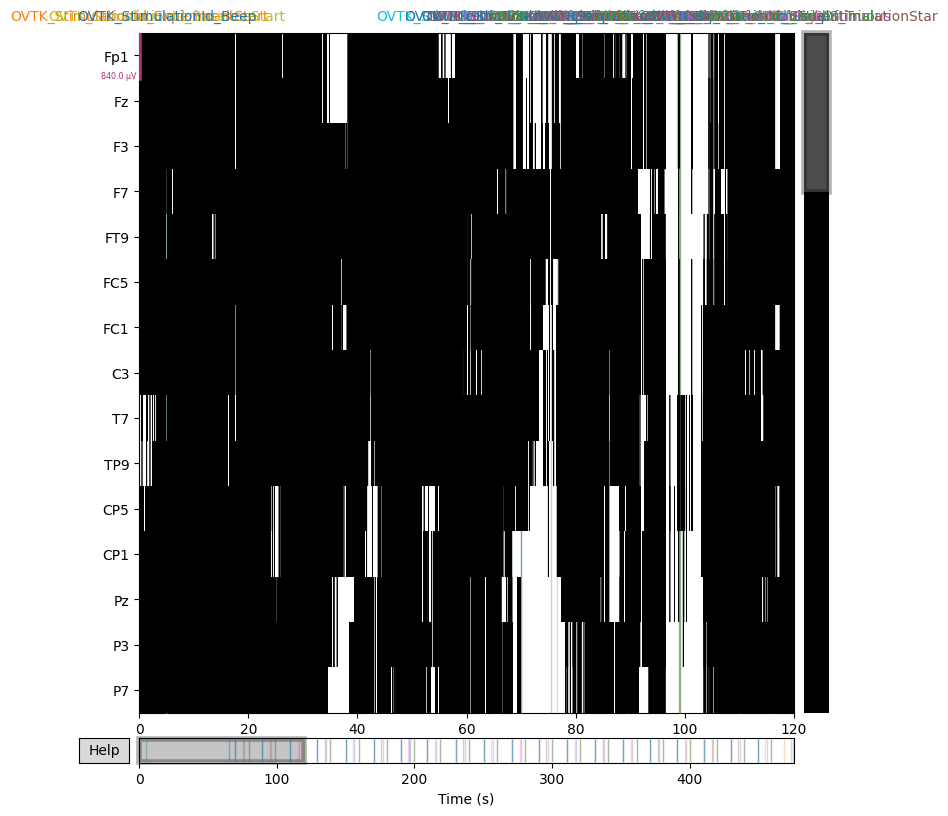

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


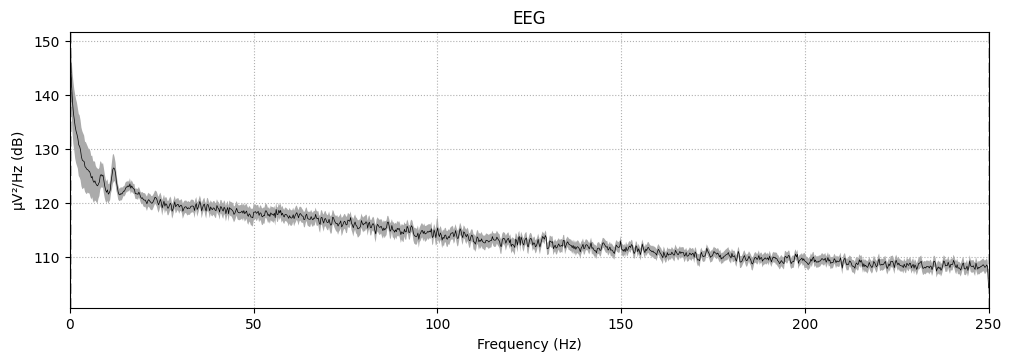

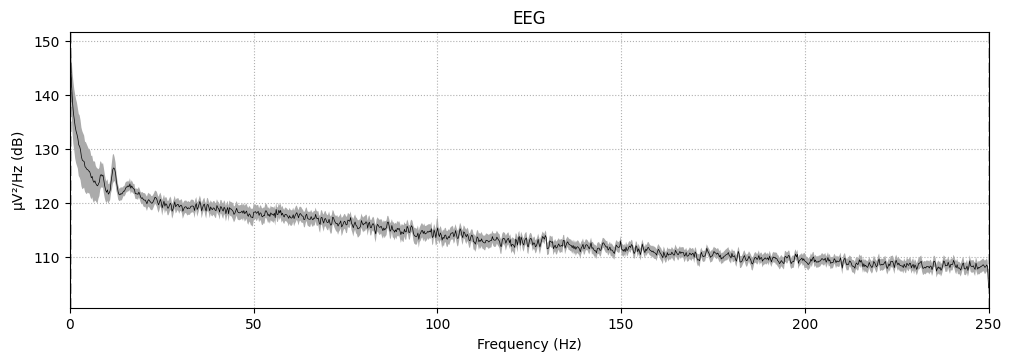

In [3]:
#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf"
input_fname2 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf"
input_fname3 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.30.16].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

In [6]:
folder = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/"
file_name = "Test-[2022.05.05-16.19.27].edf"
file = folder + file_name
data = mne.io.read_raw_edf(file, preload=True)
raw_data = data.get_data()
fs = data.info['sfreq']
total_events, dict_ = mne.events_from_annotations(data)

Extracting EDF parameters from /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.19.27].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 237999  =      0.000 ...   475.998 secs...


/tmp/ipykernel_25477/1350724273.py:4: RuntimeWarning: Invalid patient information 
  data = mne.io.read_raw_edf(file, preload=True)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']


In [36]:
dict_

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Incorrect': 5,
 'OVTK_GDF_Left': 6,
 'OVTK_GDF_Right': 7,
 'OVTK_GDF_Start_Of_Trial': 8,
 'OVTK_StimulationId_BaselineStart': 9,
 'OVTK_StimulationId_BaselineStop': 10,
 'OVTK_StimulationId_Beep': 11,
 'OVTK_StimulationId_ExperimentStart': 12,
 'OVTK_StimulationId_ExperimentStop': 13,
 'OVTK_StimulationId_Train': 14,
 'OVTK_StimulationId_VisualStimulationStar': 15}

In [37]:
raw_data.shape

(64, 238000)

In [35]:
total_events

array([[    12,      0,     12],
       [  2523,      0,      9],
       [  2523,      0,     11],
       [ 32510,      0,     10],
       [ 32510,      0,     11],
       [ 35012,      0,      8],
       [ 35012,      0,      1],
       [ 35012,      0,     11],
       [ 37769,      0,      7],
       [ 38260,      0,      4],
       [ 39757,      0,     15],
       [ 39903,      0,      3],
       [ 39903,      0,      5],
       [ 44767,      0,      8],
       [ 44767,      0,      1],
       [ 44767,      0,     11],
       [ 47513,      0,      6],
       [ 48020,      0,      4],
       [ 49518,      0,     15],
       [ 49518,      0,      3],
       [ 55013,      0,      8],
       [ 55013,      0,      1],
       [ 55013,      0,     11],
       [ 57763,      0,      7],
       [ 58265,      0,      4],
       [ 59761,      0,     15],
       [ 59761,      0,      3],
       [ 64759,      0,      8],
       [ 64759,      0,      1],
       [ 64759,      0,     11],
       [ 6

In [40]:
def load_file_eeg(sample_data_folder,filename):
    sample_Training_EDF = os.path.join(sample_data_folder, filename)
    raw_Training_EEG =  read_raw_edf(sample_Training_EDF, preload=True, verbose=False)
    events_from_annot_1,event_id_1 = mne.events_from_annotations(raw_Training_EEG,event_id='auto')
    return raw_Training_EEG, events_from_annot_1,event_id_1

def select_Event(event_name,RAW_data,events_from_annot,event_id,t_min,t_max,number_electrodes):
    epochs_training = mne.Epochs(RAW_data, events_from_annot, event_id,tmin=t_min, tmax=t_max,preload=True,event_repeated='merge',baseline = None,picks = np.arange(0,number_electrodes))
    return epochs_training[event_name]

In [41]:
folder = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/"
file_name = "Test-[2022.05.05-16.19.27].edf"
raw_training, events_from_annot,event_id = load_file_eeg(folder,file_name)
cond1 = 'OVTK_GDF_Left'
tmin = 0
tmax = 4
event_var = select_Event(cond1,raw_training,events_from_annot,event_id,tmin,tmax,64)

/tmp/ipykernel_25477/2419532697.py:3: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  read_raw_edf(sample_Training_EDF, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 2001 original time points ...
2 bad epochs dropped


In [42]:
signal = event_var.get_data()

/tmp/ipykernel_25477/754876581.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  signal = event_var.get_data()


In [43]:
print(signal.shape)

(10, 64, 2001)


In [32]:
def crossSpectrum_Welsh(x, y, nperseg=500, overlap=250, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = None, f=None):

    if f_sample is not None and f is not None:
        l = f * nperseg / f_sample
    D = nperseg - overlap
    L = nperseg
    N = len(x)
    if padding and (N - L) % D != 0:
        # Zero padding
        overflow = ((N-L)//D+1)*D + L - N
        x = np.append(x, np.zeros(overflow))
        y = np.append(y, np.zeros(overflow))

    cross = []
    freqs = None
    idx_freq = None
    ind = 0
    K = 0

    if window == 'hann':
        window = sc_signal.windows.hann(L)
    elif window == 'hamming':
        window = sc_signal.windows.hamming(L)
    elif window == 'blackman':
        window = sc_signal.windows.blackman(L)
    else:
        window = sc_signal.windows.boxcar(L)

    U = np.sum(window**2) / L
    
    while ind + L <= len(x):

        xp = x[ind : ind + L] 
        yp = y[ind : ind + L] 
        xp = sc.signal.detrend(xp, type='constant')
        yp = sc.signal.detrend(yp, type='constant')

        # Do FFT
        if mode == "scipy":
            cfx = sc.fft.fft(xp * window / L)
            cfy = sc.fft.fft(yp * window / L)
            if freqs is None and idx_freq is None:
                freqs = sc.fft.fftfreq(L, 1/f_sample)
                idx_freq = np.argwhere((freqs >= 4) & (freqs <= 100)).flatten()
                freqs = freqs[idx_freq]
            cfx = cfx[idx_freq]
            cfy = cfy[idx_freq]
    
        if mode == "manual":
            exp_vector = np.exp(-2j * np.pi * np.arange(L) * l / L)
            cfx = np.dot(xp * window / L, exp_vector)
            cfy = np.dot(yp * window / L, exp_vector)

        # Get cross spectrum
        cross.append(cfx.conj()*cfy)

        ind += D
        K += 1
    
    cross = np.array(cross) 
    
    return cross,freqs

In [33]:
list_name_channels = ["CP3"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]
signal = raw_data[list_idx_channels,:].reshape(-1)
cross,freqs = crossSpectrum_Welsh(signal, signal, nperseg=500, overlap=250, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = fs, f=None)

In [34]:
N_mean = 200
for i in range(20)

array([  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
        92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])